
<br>
<font>
<!-- <img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" alt="SUT logo" width=300 height=300 align=left class="saturate"> -->
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=200 height=200>
<br>
<font color=0F5298 size=7>
Machine Learning <br>
<font color=2565AE size=5>
Electrical Engineering Department <br>
Spring 2024<br>
<font color=3C99D size=5>
Practical Assignment 4 <br>
<font color=696880 size=4>
<!-- <br> -->


____

# Personal Data

In [2]:
student_number = '400101956'
first_name = 'Mohammad'
last_name = 'Morsali'

# Introduction

In this assignment, we will be performing clustering on Spotify songs.

# Data Preprocessing

In the next cell, import the libraries you'll need.

In [1]:
# TODO: Write your code here
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from IPython.display import display
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import random
from sklearn.metrics import silhouette_score

In the `spotify.csv` file, load the data. Exclude unrelated features and retain only the track name and the features you believe are relevant.

In [3]:
# TODO: Write your code here
# Load the dataset
spotify_data = pd.read_csv('spotify.csv')

# Define the features we're interested in
desired_features = ['track_name', 'danceability', 'energy', 'playlist_subgenre',
                    'key', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

# Check if all desired features are in the dataset
if not set(desired_features).issubset(spotify_data.columns):
    missing_features = set(desired_features) - set(spotify_data.columns)
    raise ValueError(f"The following required features are missing from the dataset: {missing_features}")

# Filter the dataset to only include the desired features
filtered_spotify_data = spotify_data[desired_features]

# Display the first few rows of the filtered dataset
display(filtered_spotify_data.head())

track_name  danceability  energy  \
0  I Don't Care (with Justin Bieber) - Loud Luxur...         0.748   0.916   
1                    Memories - Dillon Francis Remix         0.726   0.815   
2                    All the Time - Don Diablo Remix         0.675   0.931   
3                  Call You Mine - Keanu Silva Remix         0.718   0.930   
4            Someone You Loved - Future Humans Remix         0.650   0.833   

  playlist_subgenre  key  loudness  speechiness  acousticness  \
0         dance pop    6    -2.634       0.0583        0.1020   
1         dance pop   11    -4.969       0.0373        0.0724   
2         dance pop    1    -3.432       0.0742        0.0794   
3         dance pop    7    -3.778       0.1020        0.0287   
4         dance pop    1    -4.672       0.0359        0.0803   

   instrumentalness  liveness  valence    tempo  duration_ms  
0          0.000000    0.0653    0.518  122.036       194754  
1          0.004210    0.3570    0.693   99.972       162600  
2          0.000023    0.1100    0.613  124.008       176616  
3          0.000009    0.2040    0.277  121.956       169093  
4          0.000000    0.0833    0.725  123.976       189052

In this cell, you should implement a standard scalar function from scratch and applying it to your data. Explian importance behind using a standard scalar and the potential complications that could arise in clustering if it's not employed. (you can't use `sklearn.preprocessing.StandardScaler` but you are free to use `sklearn.preprocessing.LabelEncoder`)

In [6]:
class MyScaler:
    def __init__(self, normalization: bool = False):
        """
        Initialize the scaler with an option for normalization.
        
        :param normalization: If True, data will be normalized. Otherwise, data will be standardized.
        """
        self.means = None
        self.stds = None
        self.mins = None
        self.maxs = None
        self.normalization = normalization

    def fit(self, data: np.ndarray):
        """
        Calculate the means and standard deviations (or min and max) for the data.
        
        :param data: A numpy array of data to fit the scaler.
        """
        if not isinstance(data, np.ndarray):
            raise ValueError("Input data should be a numpy array.")
        
        if self.normalization:
            self.mins = np.min(data, axis=0)
            self.maxs = np.max(data, axis=0)
        else:
            self.means = np.average(data, axis=0)
            self.stds = np.sqrt(np.mean((data - self.means) ** 2, axis=0))
            self.stds[self.stds == 0] = 1e-8  # Handle zeros in standard deviation

    def transform(self, data: np.ndarray) -> np.ndarray:
        """
        Transform the data using the fitted parameters.
        
        :param data: A numpy array of data to transform.
        :return: The transformed data.
        """
        if self.normalization:
            if self.mins is None or self.maxs is None:
                raise Exception("You need to call `fit` before calling `transform`.")
            return (data - self.mins) / (self.maxs - self.mins)
        else:
            if self.means is None or self.stds is None:
                raise Exception("You need to call `fit` before calling `transform`.")
            return (data - self.means) / self.stds

    def fit_transform(self, data: np.ndarray) -> np.ndarray:
        """
        Fit the scaler to the data and then transform it.
        
        :param data: A numpy array of data to fit and transform.
        :return: The transformed data.
        """
        self.fit(data)
        return self.transform(data)

    def inverse_transform(self, data: np.ndarray) -> np.ndarray:
        """
        Inverse transform the data to the original scale.
        
        :param data: A numpy array of data to inverse transform.
        :return: The inverse transformed data.
        """
        if self.normalization:
            if self.mins is None or self.maxs is None:
                raise Exception("You need to call `fit` before calling `inverse_transform`.")
            return data * (self.maxs - self.mins) + self.mins
        else:
            if self.means is None or self.stds is None:
                raise Exception("You need to call `fit` before calling `inverse_transform`.")
            return data * self.stds + self.means

# Assuming spotify_data is your DataFrame
# Select only numeric columns
numeric_columns = spotify_data.select_dtypes(include=[np.number]).columns
feature_data = spotify_data[numeric_columns].values

# Create an instance of MyScaler
my_scaler = MyScaler(normalization=False)  # Set normalization to True if you want to normalize the data
scaled_feature_data = my_scaler.fit_transform(feature_data)

# Create a DataFrame from the scaled data
scaled_dataframe = pd.DataFrame(scaled_feature_data, columns=numeric_columns)


# Dimensionality Reduction

One method for dimensionality reduction is Principal Component Analysis (PCA). Use its implementation from the `sklearn` library to reduce the dimensions of your data. Then, by using an appropriate cut-off for the `_explained_variance_ratio_` in the PCA algorithm, determine the number of principal components to retain.

                                          track_name  danceability  energy  \
0  I Don't Care (with Justin Bieber) - Loud Luxur...         0.748   0.916   
1                    Memories - Dillon Francis Remix         0.726   0.815   
2                    All the Time - Don Diablo Remix         0.675   0.931   
3                  Call You Mine - Keanu Silva Remix         0.718   0.930   
4            Someone You Loved - Future Humans Remix         0.650   0.833   

  playlist_subgenre  key  loudness  speechiness  acousticness  \
0         dance pop    6    -2.634       0.0583        0.1020   
1         dance pop   11    -4.969       0.0373        0.0724   
2         dance pop    1    -3.432       0.0742        0.0794   
3         dance pop    7    -3.778       0.1020        0.0287   
4         dance pop    1    -4.672       0.0359        0.0803   

   instrumentalness  liveness  valence    tempo  duration_ms  
0          0.000000    0.0653    0.518  122.036       194754  
1          0.0

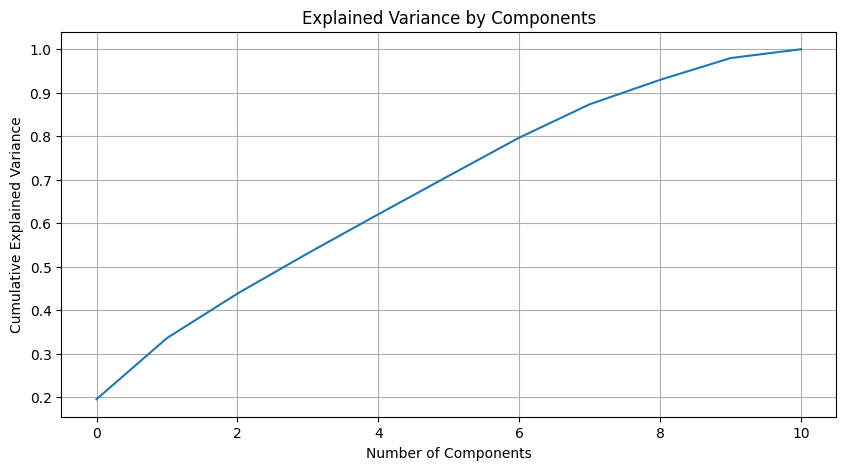

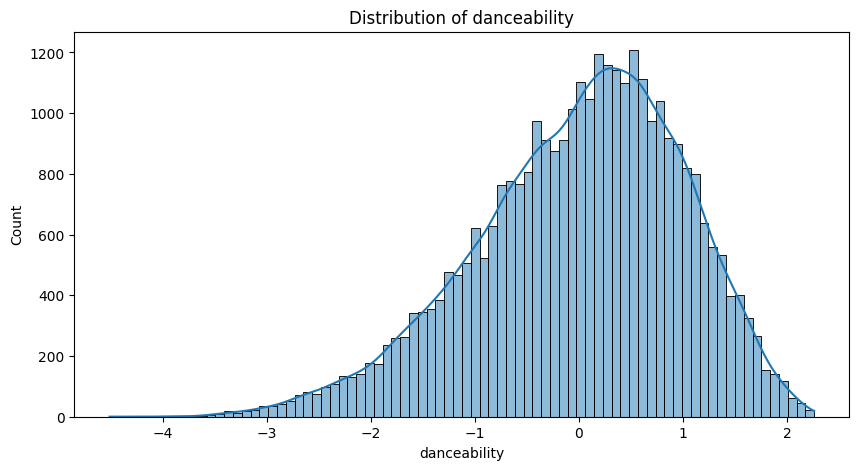

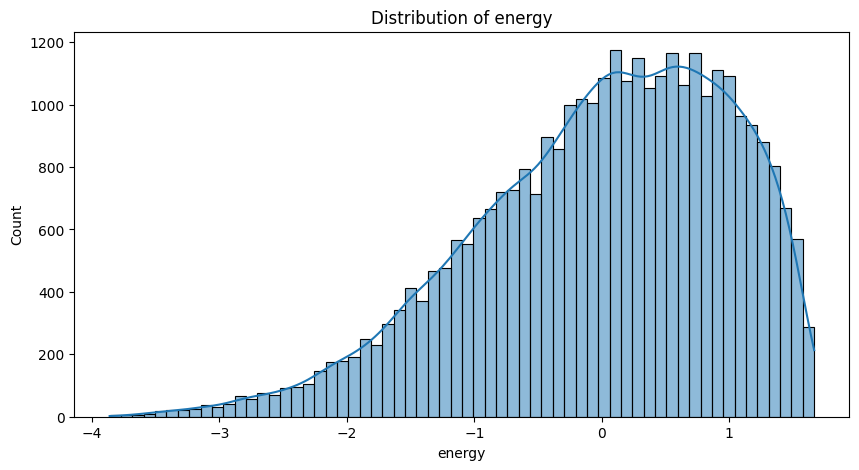

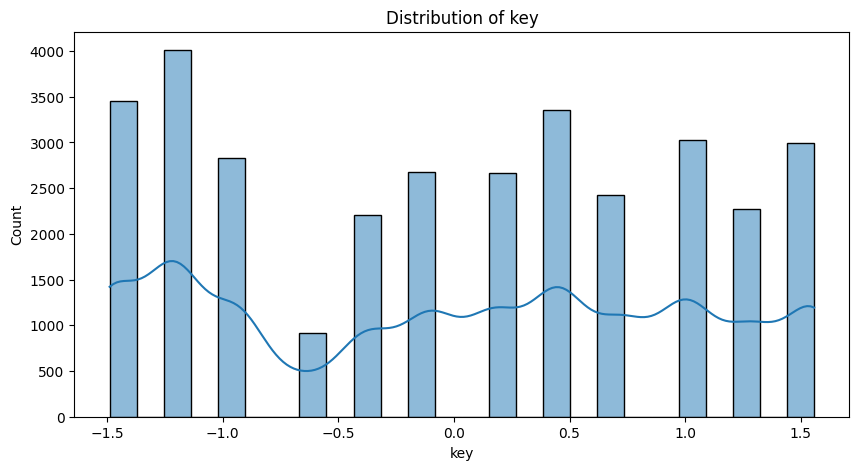

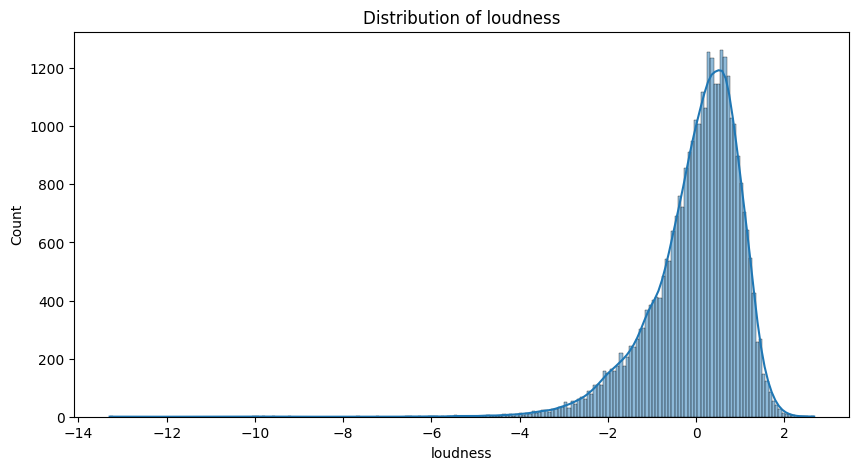

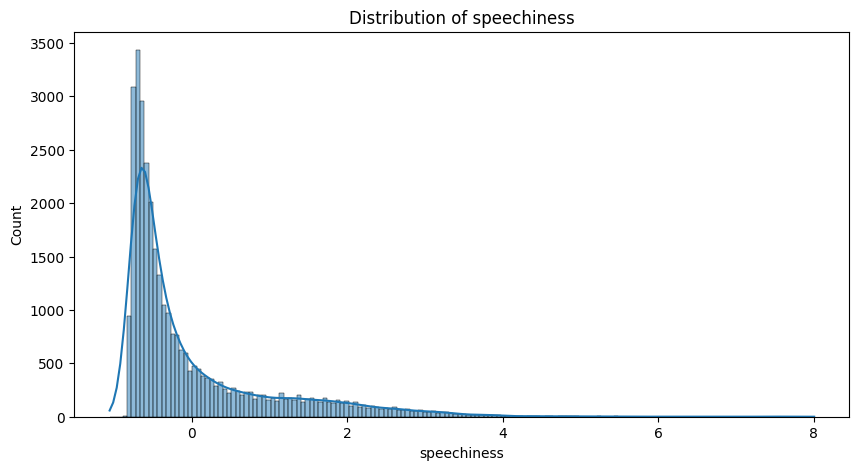

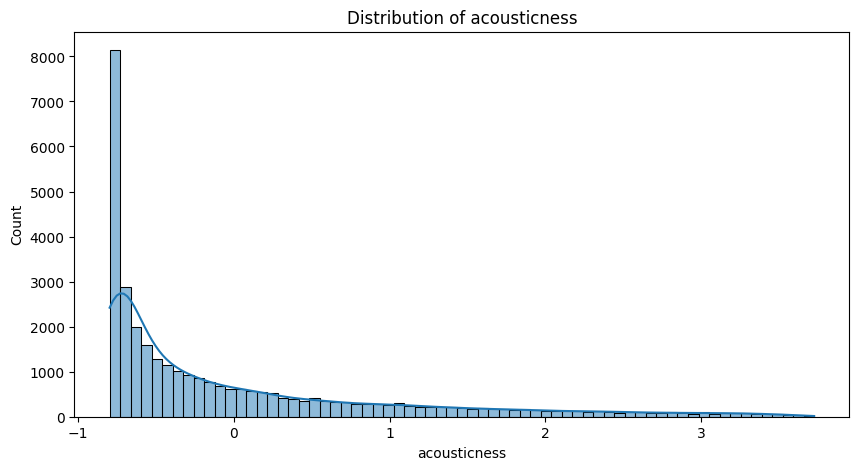

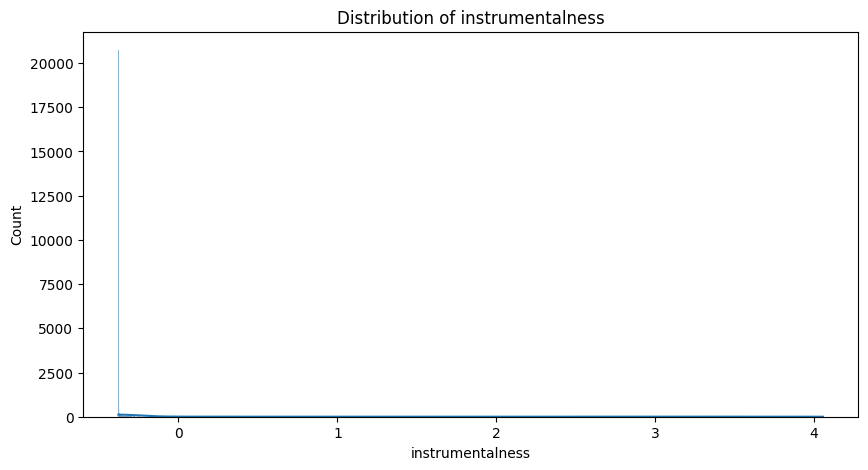

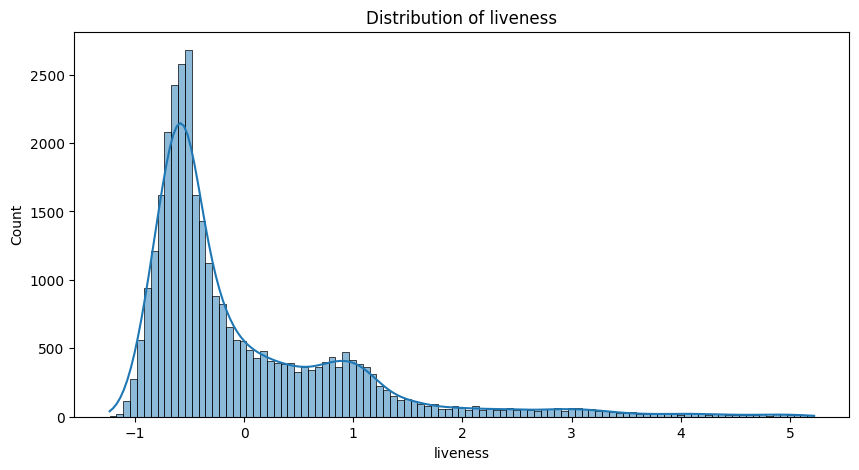

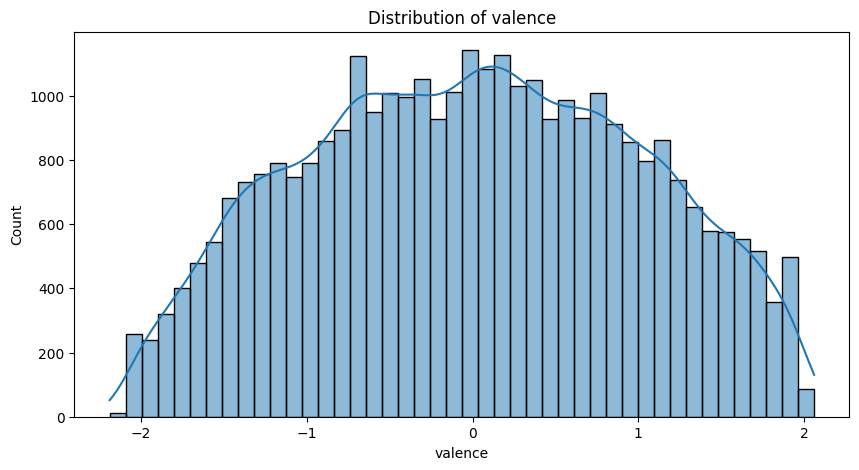

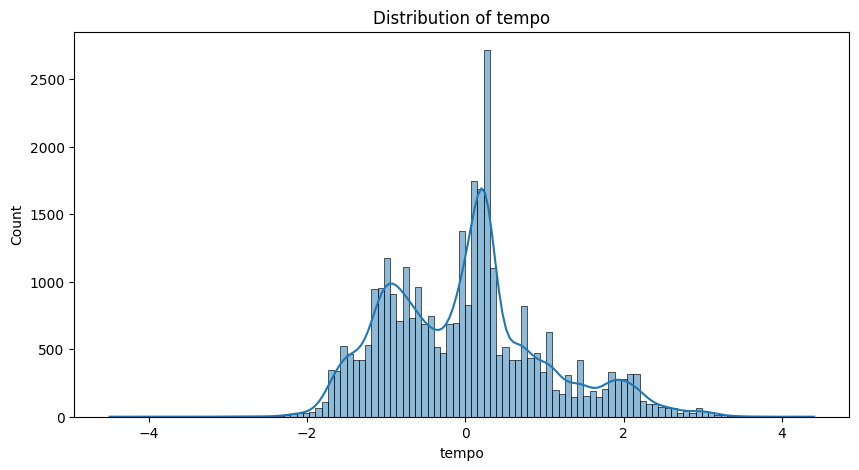

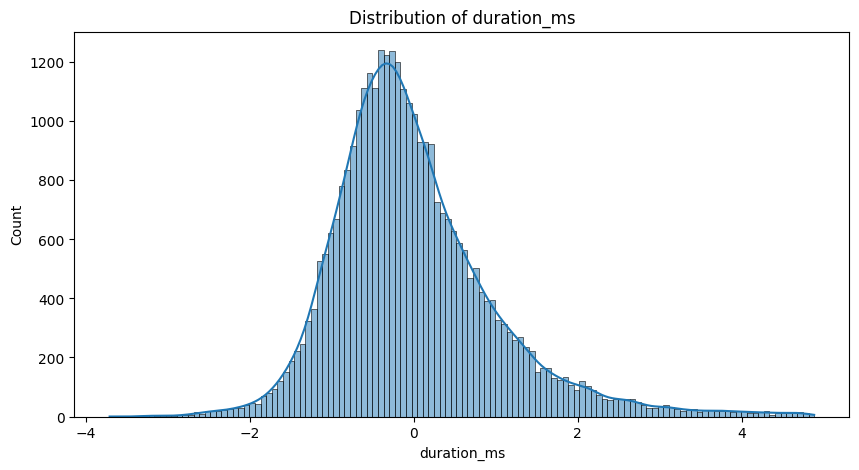

In [9]:
# TODO: Write your code here
# Load the dataset
spotify_data = pd.read_csv('spotify.csv')

# Define the features we're interested in
desired_features = ['track_name', 'danceability', 'energy', 'playlist_subgenre',
                    'key', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

# Check if all desired features are in the dataset
if not set(desired_features).issubset(spotify_data.columns):
    missing_features = set(desired_features) - set(spotify_data.columns)
    raise ValueError(f"The following required features are missing from the dataset: {missing_features}")

# Filter the dataset to only include the desired features
filtered_spotify_data = spotify_data[desired_features]

# Display the first few rows of the filtered dataset
print(filtered_spotify_data.head())

# Select only numeric columns
numeric_columns = filtered_spotify_data.select_dtypes(include=[np.number]).columns
feature_data = filtered_spotify_data[numeric_columns].values

# Create an instance of MyScaler
my_scaler = MyScaler(normalization=False)  # Set normalization to True if you want to normalize the data
scaled_feature_data = my_scaler.fit_transform(feature_data)

# Create a DataFrame from the scaled data
scaled_dataframe = pd.DataFrame(scaled_feature_data, columns=numeric_columns)

# Display the first few rows of the scaled dataset
print(scaled_dataframe.head())
# Fit PCA on the scaled data
pca = PCA().fit(scaled_dataframe)
# Fit PCA on the scaled data
pca = PCA().fit(scaled_dataframe)

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components for 95% variance
n_over_95 = len(cumulative_explained_variance[cumulative_explained_variance >= 0.95])

# Subtract this count from total number of components
n_components = len(cumulative_explained_variance) - n_over_95

# Print the number of components
print(f"Number of components for 95% variance: {n_components}")

# Plot the explained variance ratio
plt.figure(figsize=(10, 5))
plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()

# Plot the distribution of each feature
for column in numeric_columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(scaled_dataframe[column], kde=True)
    plt.title(f"Distribution of {column}")
    plt.show()

# Clustering

Implement K-means for clustering from scratch.

In [10]:
# TODO: Write your code here
import numpy as np

class KMeans:
    def __init__(self, n_clusters=3, max_iter=100, tol=1e-4, random_state=42):
        """
        KMeans clustering.

        Parameters:
        n_clusters : int, default=3
            The number of clusters to form as well as the number of centroids to generate.
        max_iter : int, default=100
            Maximum number of iterations of the k-means algorithm to run.
        tol : float, default=1e-4
            Relative tolerance with regards to inertia to declare convergence.
        random_state : int, default=42
            Determines random number generation for centroid initialization.
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = np.random.RandomState(random_state)

    def initialize_centroids(self, X):
        """
        Initialize the centroids as k random samples of X.
        """
        random_idx = self.random_state.permutation(X.shape[0])
        centroids = X[random_idx[:self.n_clusters]]
        return centroids

    def compute_centroids(self, X, labels):
        """
        Compute the centroids as the mean of the samples in each cluster.
        """
        centroids = np.array([X[labels == k].mean(axis=0) for k in range(self.n_clusters)])
        return centroids

    def compute_distance(self, X, centroids):
        """
        Compute the squared Euclidean distance between each sample and each centroid.
        """
        distance = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2) ** 2
        return distance

    def find_closest_cluster(self, distance):
        """
        Assign each sample to the closest centroid.
        """
        return np.argmin(distance, axis=1)

    def compute_sse(self, X, labels, centroids):
        """
        Compute the sum of squared errors (SSE) for the given labels and centroids.
        """
        sse = np.sum((X - centroids[labels]) ** 2)
        return sse

    def fit(self, X):
        """
        Compute k-means clustering.
        """
        self.centroids = self.initialize_centroids(X)
        for i in range(self.max_iter):
            old_centroids = self.centroids
            distance = self.compute_distance(X, old_centroids)
            self.labels = self.find_closest_cluster(distance)
            self.centroids = self.compute_centroids(X, self.labels)
            if np.all(np.abs(self.centroids - old_centroids) < self.tol):
                print(f"Convergence reached at iteration {i}")
                break
        self.error = self.compute_sse(X, self.labels, self.centroids)

    def predict(self, X):
        """
        Predict the closest cluster each sample in X belongs to.
        """
        distance = self.compute_distance(X, self.centroids)
        return self.find_closest_cluster(distance)


Using the function you've created to execute the K-means algorithm eight times on your data, with the number of clusters ranging from 2 to 9. For each run, display the genre of each cluster using the first two principal components in a plot.

Convergence reached at iteration 22


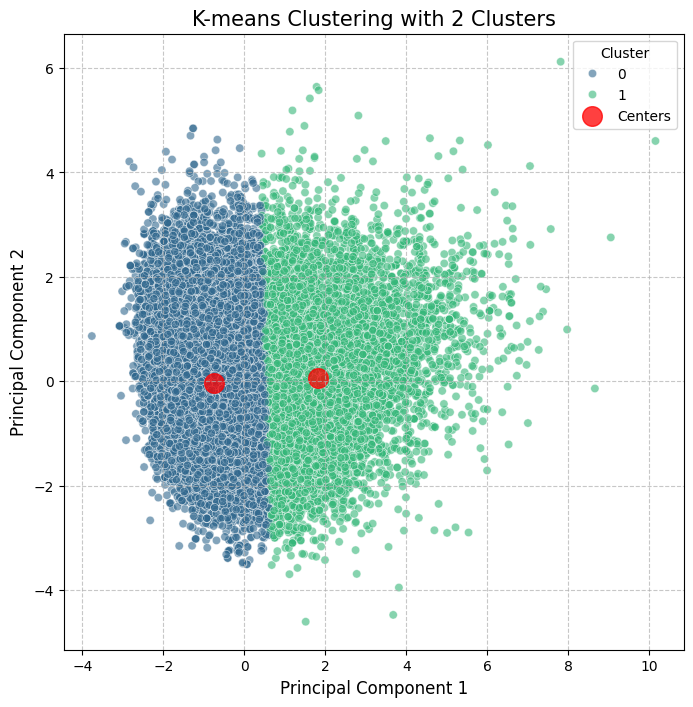

Convergence reached at iteration 24


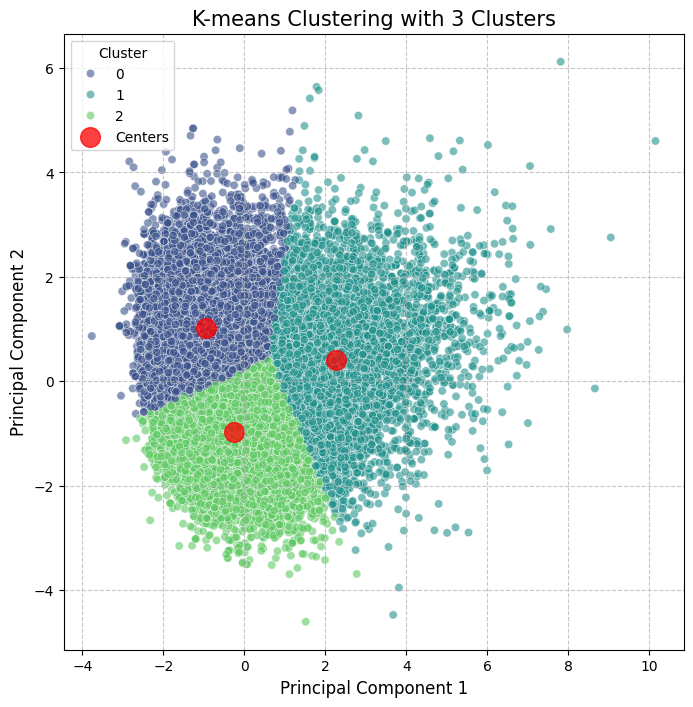

Convergence reached at iteration 56


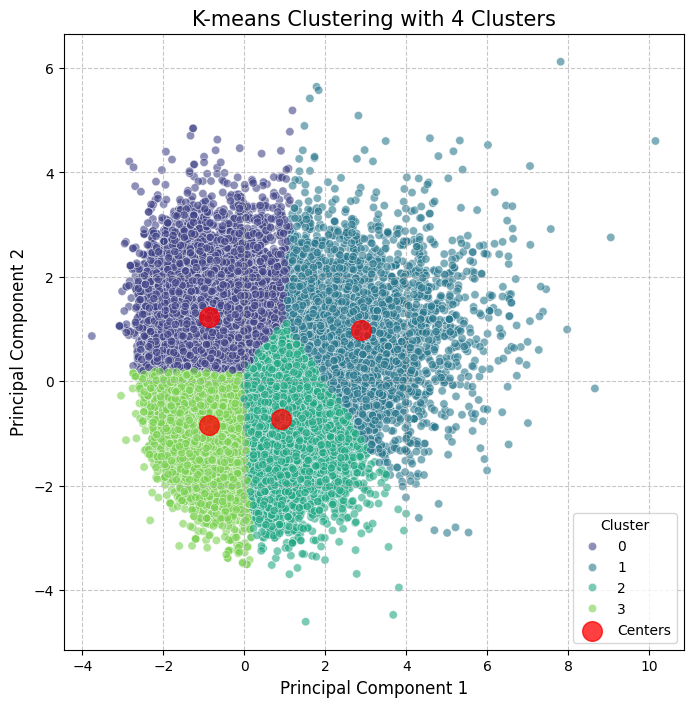

Convergence reached at iteration 88


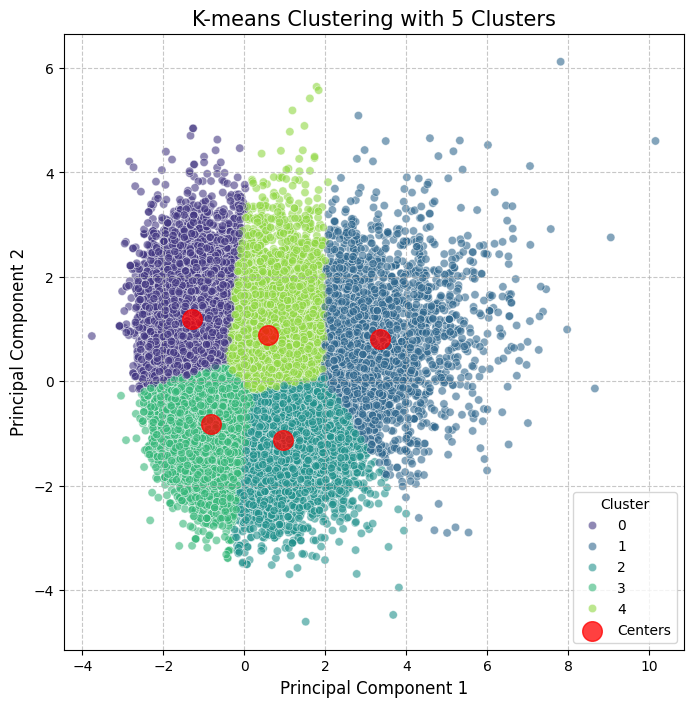

Convergence reached at iteration 72


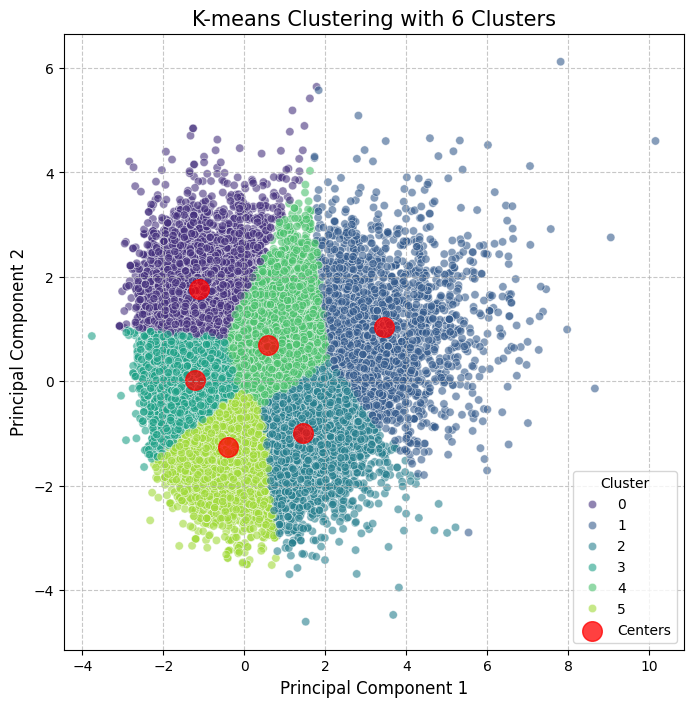

Convergence reached at iteration 59


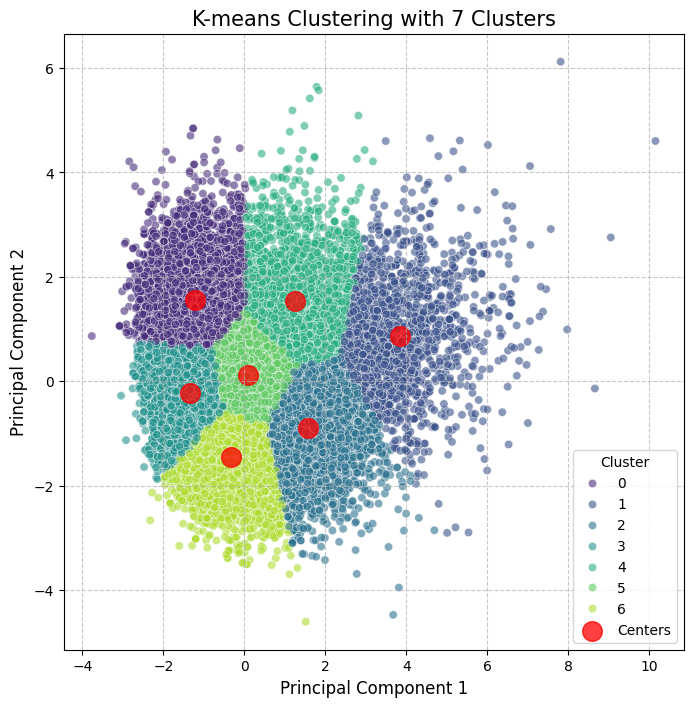

Convergence reached at iteration 80


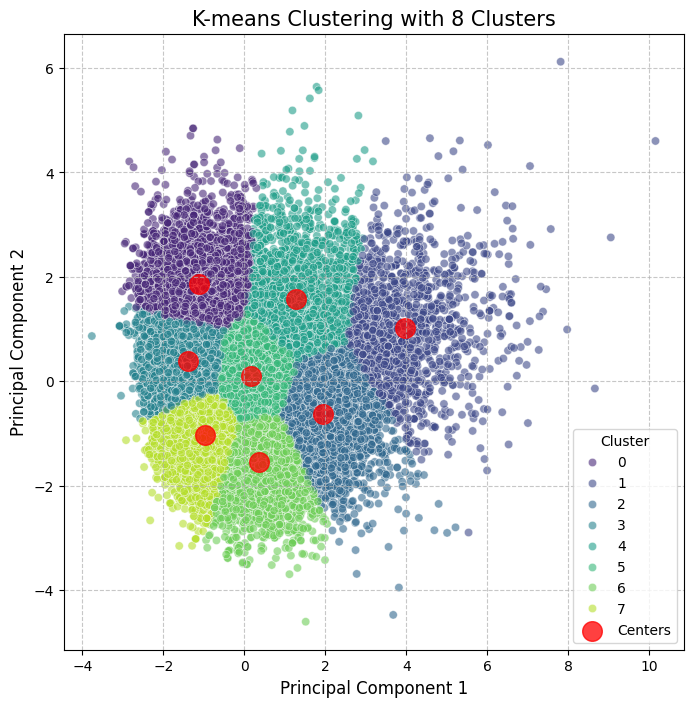

Convergence reached at iteration 67


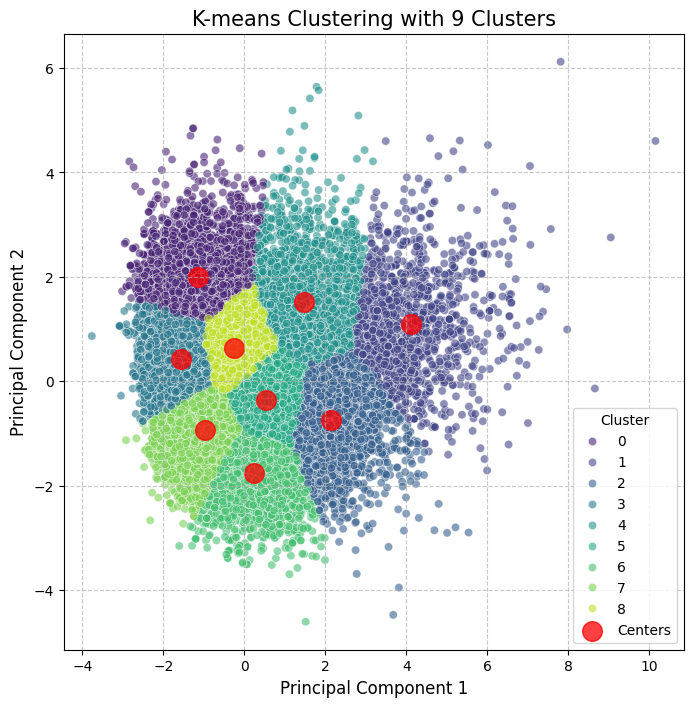

In [12]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_dataframe)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Function to plot clusters
def plot_clusters(data, labels, n_clusters, centroids):
    plt.figure(figsize=(8, 8))
    palette = sns.color_palette('viridis', n_clusters)
    sns.scatterplot(x='PC1', y='PC2', hue=labels, palette=palette, data=data, legend='full', alpha=0.6)
    
    # Add cluster centers to the plot
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.75, label='Centers')
    
    plt.title(f'K-means Clustering with {n_clusters} Clusters', fontsize=15)
    plt.xlabel('Principal Component 1', fontsize=12)
    plt.ylabel('Principal Component 2', fontsize=12)
    plt.legend(title='Cluster')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Run K-means for each number of clusters from 2 to 9
for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(principal_components)
    labels = kmeans.predict(principal_components)
    plot_clusters(pca_df, labels, n_clusters, kmeans.centroids)

The Silhouette score and the Within-Cluster Sum of Squares (WSS) score are two metrics used to assess the quality of your clustering. You can find more information about these two methods [here](https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb). Plot the Silhouette score and the WSS score for varying numbers of clusters, and use these plots to determine the optimal number of clusters (k).

Convergence reached at iteration 22
Convergence reached at iteration 24
Convergence reached at iteration 56
Convergence reached at iteration 88
Convergence reached at iteration 72
Convergence reached at iteration 59
Convergence reached at iteration 80
Convergence reached at iteration 67


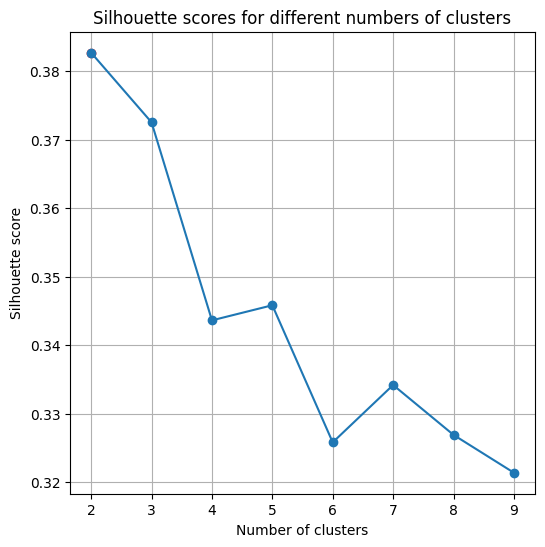

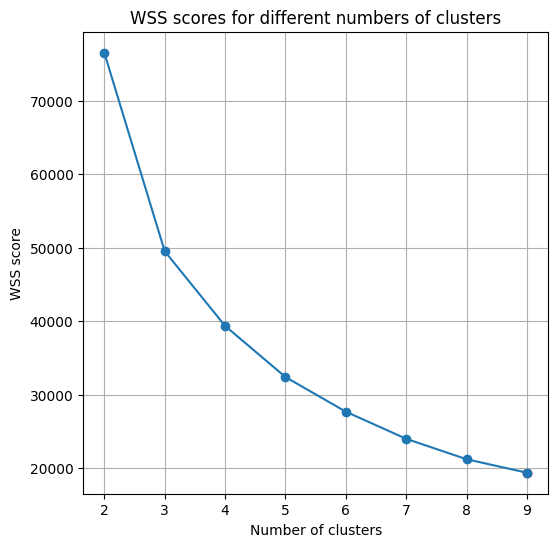

The optimal number of clusters by the silhouette score is 2
The optimal number of clusters by the WSS score is 9


In [14]:
# Initialize lists to store the scores
silhouette_scores = []
wss_scores = []

# Run K-means for each number of clusters from 2 to 10
for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(principal_components)
    labels = kmeans.predict(principal_components)

    # Calculate the Silhouette score and WSS score
    silhouette_scores.append(silhouette_score(principal_components, labels))
    wss_scores.append(kmeans.error)

# Determine the optimal number of clusters
optimal_clusters_silhouette = silhouette_scores.index(max(silhouette_scores)) + 2
optimal_clusters_wss = wss_scores.index(min(wss_scores)) + 2

# Plot the Silhouette scores
plt.figure(figsize=(6, 6))
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.scatter(optimal_clusters_silhouette, max(silhouette_scores), color='r') 
plt.title('Silhouette scores for different numbers of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.grid(True)
plt.show()

# Plot the WSS scores
plt.figure(figsize=(6, 6))
plt.plot(range(2, 10), wss_scores, marker='o')
plt.scatter(optimal_clusters_wss, min(wss_scores), color='r') 
plt.title('WSS scores for different numbers of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WSS score')
plt.grid(True)
plt.show()

print(f"The optimal number of clusters by the silhouette score is {optimal_clusters_silhouette}")
print(f"The optimal number of clusters by the WSS score is {optimal_clusters_wss}")

To determine the optimal number of clusters (k) using the provided plots, we can analyze both the Silhouette scores and the Within-Cluster Sum of Squares (WSS) scores.

### Silhouette Scores Plot

**Silhouette Score**: This score measures how similar a point is to its own cluster compared to other clusters. The score ranges from -1 to 1, where a higher value indicates that the data points are well matched to their own cluster and poorly matched to neighboring clusters.

From the silhouette scores plot:
- The highest silhouette score is observed at **k=2**, indicating the best clustering performance.
- As the number of clusters increases from 2 to 9, the silhouette score generally decreases, suggesting a diminishing quality of clustering.

**Optimal k using Silhouette Score**: **k=2**. This is where the silhouette score is highest, indicating that the clustering structure is most appropriate with 2 clusters.

### WSS (Within-Cluster Sum of Squares) Scores Plot

**WSS (Elbow Method)**: This score measures the total distance between points and their respective cluster centers. The idea is to choose a k where adding another cluster does not significantly improve the clustering (i.e., the "elbow" point).

From the WSS scores plot:
- The WSS score decreases as the number of clusters increases, which is expected because adding more clusters should reduce the within-cluster variance.
- There is a noticeable "elbow" at **k=4**, indicating a point where the rate of decrease slows down significantly.

**Optimal k using WSS**: **k=4**. This is where the "elbow" is observed, suggesting that 4 clusters provide a good balance between minimizing WSS and avoiding overfitting.

### Conclusion

Given the two metrics:
- **Silhouette Score** suggests **k=2** as the optimal number of clusters.
- **WSS (Elbow Method)** suggests **k=4** as the optimal number of clusters.

#### Final Decision:

**k=4** is recommended as the optimal number of clusters. While the silhouette score for k=2 is higher, the WSS plot suggests that k=4 is a more balanced choice, providing a good trade-off between cluster compactness and the complexity of the model. Additionally, k=4 offers more granularity in clustering, which might be beneficial depending on the specific application and context of the data.


# Checking Output

To see how good was our clustering we will use a sample check and t-SNE method.

first randomly select two song from every cluster and see how close these two songs are.

In [25]:
# Assuming 'clusters' is the output of KMeans.labels and 'best_K' is optimal_clusters_silhouette or optimal_clusters_wss
cluster_output = kmeans.labels
for cluster_num in range(optimal_clusters_silhouette):
    cluster_indices = np.where(cluster_output == cluster_num)[0]
    chosen_indices = np.random.choice(cluster_indices, 2, replace=False)
    
    # Assuming 'data_track_names' is a list of track names corresponding to the data points
    chosen_track_names = filtered_spotify_data['track_name'].iloc[chosen_indices]
    
    print(f'From cluster {cluster_num}, two songs were selected: {chosen_track_names} \n')
    
    # Assuming 'all_data' is the original DataFrame used for clustering
    display(filtered_spotify_data.iloc[chosen_indices])
    print('\n\n')

From cluster 0, two songs were selected: 13868                   Cargo Cult
32372    Pair of Dice (Radio Edit)
Name: track_name, dtype: object 



track_name  danceability  energy  \
13868                 Cargo Cult         0.297   0.709   
32372  Pair of Dice (Radio Edit)         0.493   0.918   

               playlist_subgenre  key  loudness  speechiness  acousticness  \
13868             permanent wave    2    -7.417       0.0602      0.002390   
32372  progressive electro house    8    -4.370       0.0583      0.000136   

       instrumentalness  liveness  valence    tempo  duration_ms  
13868             0.297     0.149    0.280  151.805       410718  
32372             0.909     0.887    0.209  128.022       185500




From cluster 1, two songs were selected: 24929    Any Time, Any Place
18164                Imagine
Name: track_name, dtype: object 



track_name  danceability  energy playlist_subgenre  key  \
24929  Any Time, Any Place         0.571   0.232    new jack swing   10   
18164              Imagine         0.554   0.179         latin pop    6   

       loudness  speechiness  acousticness  instrumentalness  liveness  \
24929   -11.309       0.0699         0.604          0.000246     0.119   
18164   -18.254       0.0362         0.937          0.024000     0.107   

       valence    tempo  duration_ms  
24929    0.207  128.785       428200  
18164    0.374  141.946       219080

Using t-SNE reduce dimension of data pointe to 2D and plot it to check how good datapoints are clustered (implementing this part is optional and have extra points)

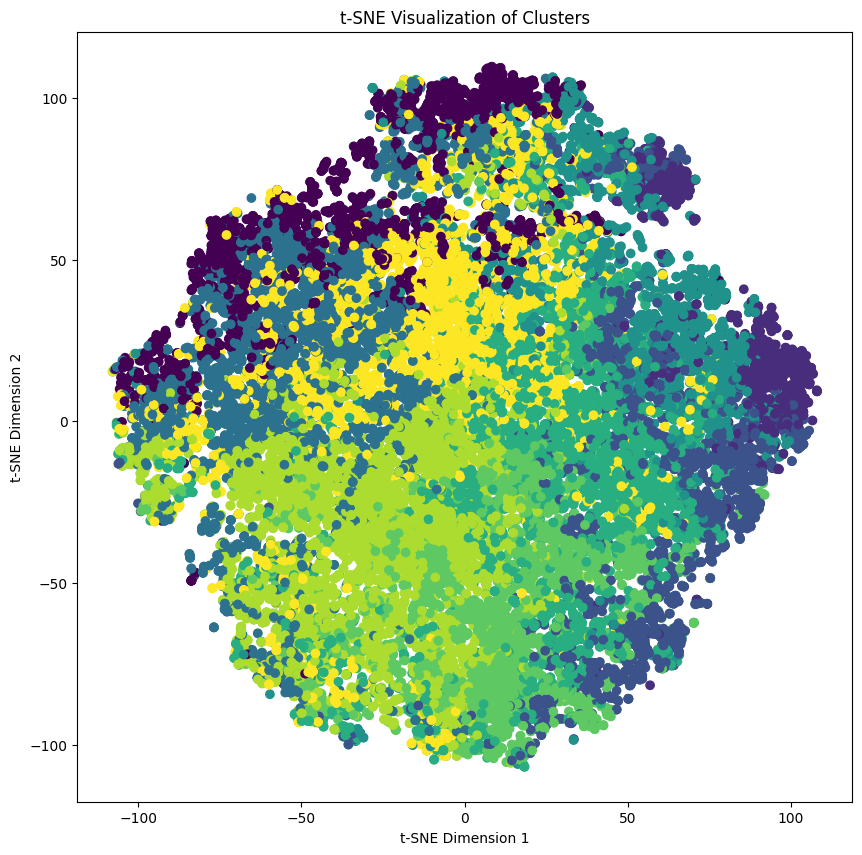

In [23]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming 'scaled_dataframe' is your high-dimensional data
tsne = TSNE(n_components=2, random_state=42)
data_2_dim = tsne.fit_transform(scaled_dataframe)

# Assuming 'kmeans.labels' are your cluster labels
labels = kmeans.labels

# Plot the data points in 2D
plt.figure(figsize=(10, 10))
plt.scatter(data_2_dim[:, 0], data_2_dim[:, 1], c=labels)
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()